In [ ]:
import os

# Unzip train and test files
#!unzip -q '/content/drive/MyDrive/covid_xray_dataset/train'  -d '/content/train_data'
# !unzip -q '/content/drive/MyDrive/covid_xray_dataset/test' -d '/content/test_data'

unzip:  cannot find or open /content/drive/MyDrive/covid_xray_dataset/train, /content/drive/MyDrive/covid_xray_dataset/train.zip or /content/drive/MyDrive/covid_xray_dataset/train.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/covid_xray_dataset/test, /content/drive/MyDrive/covid_xray_dataset/test.zip or /content/drive/MyDrive/covid_xray_dataset/test.ZIP.


In [ ]:
! pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Basic Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CNN Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

from keras_tuner.engine.hyperparameters import HyperParameters

# Metric Libraries
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:

# Unzip train and test files
#  !unzip -q '/content/drive/MyDrive/trainzip'  -d '/content/train_data'
#  !unzip -q '/content/drive/MyDrive/testzip' -d '/content/test_data'

unzip:  cannot find or open /content/drive/MyDrive/trainzip, /content/drive/MyDrive/trainzip.zip or /content/drive/MyDrive/trainzip.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/testzip, /content/drive/MyDrive/testzip.zip or /content/drive/MyDrive/testzip.ZIP.


In [ ]:
import os

# Unzip train and test files
#  !unzip -q '/content/drive/MyDrive/covid_xray_dataset/train'  -d '/content/train_data'
#  !unzip -q '/content/drive/MyDrive/covid_xray_dataset/test' -d '/content/test_data'

# Update train_dir and test_dir to point to the unzipped directories
train_dir = '/content/train_data'
test_dir = '/content/test_data'

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

unzip:  cannot find or open /content/drive/MyDrive/covid_xray_dataset/train, /content/drive/MyDrive/covid_xray_dataset/train.zip or /content/drive/MyDrive/covid_xray_dataset/train.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/covid_xray_dataset/test, /content/drive/MyDrive/covid_xray_dataset/test.zip or /content/drive/MyDrive/covid_xray_dataset/test.ZIP.
Train directory: /content/train_data
Test directory: /content/test_data


In [ ]:
train_dir = '/content/drive/MyDrive/covid_xray_dataset/train'
test_dir = '/content/drive/MyDrive/covid_xray_dataset/test'


In [ ]:
train_dir

'/content/drive/MyDrive/covid_xray_dataset/train'

In [ ]:
# Function to convert individual images as dataframe
def create_df(data_path):

    file_paths = []
    file_labels = []

    for inst in os.listdir(data_path):
        f_path = os.path.join(data_path, inst)
        if os.path.isdir(f_path):
            images = os.listdir(f_path)
            for img in images:
                img_path = os.path.join(f_path, img)
                file_paths.append(img_path)
                file_labels.append(inst)

    file_series = pd.Series(file_paths, name='FilePaths')
    label_series = pd.Series(file_labels, name='Labels')

    return pd.concat([file_series, label_series], axis=1)

In [ ]:
# creating data frame for test and train data
train_df = create_df(train_dir)
test_df = create_df(test_dir)

In [ ]:
# dimension of the data
print(train_df.shape)
print(test_df.shape)

(148, 2)
(40, 2)


In [ ]:
train_df.head()

,FilePaths,Labels
0,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
1,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
2,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
3,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL
4,/content/drive/MyDrive/covid_xray_dataset/trai...,NORMAL


In [ ]:
# create synthetic data by data agumentation

train_datagen = ImageDataGenerator( rescale = 1./255,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    fill_mode = 'nearest'
                                    )
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Data Generator

# training
train_generator = train_datagen.flow_from_dataframe(
                    dataframe = train_df,
                    x_col = 'FilePaths',
                    y_col = 'Labels',
                    target_size = (224, 224),
                    batch_size = 32,
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 42)

# testing
test_generator = test_datagen.flow_from_dataframe(
                    dataframe = test_df,
                    x_col = 'FilePaths',
                    y_col = 'Labels',
                    target_size = (224, 224),
                    batch_size = 32,
                    class_mode = 'categorical',
                    shuffle = False)

Found 148 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [ ]:
train_generator

In [ ]:
test_generator

In [ ]:
# CNN Archeticture

def build_model(hp):
   model = Sequential([
       Conv2D(filters = hp.Int('con1_filter', min_value = 32, max_value = 128, step = 8 ),
              kernel_size = hp.Choice('conv1_kernel', values=[3,4,5,6]),
              activation = hp.Choice('con1_activation', ['relu', 'tanh']),
              input_shape = (224, 224, 3)),
       MaxPooling2D((2,2)),

       Conv2D(filters = hp.Int('con2_filter', min_value = 32, max_value = 68, step = 8),
              kernel_size = hp.Choice('con2_kernel',  values =[2,3,4]),
              activation = hp.Choice('con2_activation', ['relu', 'tanh']),
              padding = 'same'),
        MaxPooling2D((2,2)),

        Conv2D(filters = hp.Int('cov3_filter', min_value=32, max_value = 68, step = 8),
               kernel_size = hp.Choice('con3_kernel', values = [2,3,4]),
               activation = hp.Choice('con3_activation', ['relu', 'tanh']),
               padding = 'same'),
        MaxPooling2D((2,2)),

        Flatten(),

        Dense(units = hp.Int('dense1_units', min_value = 120, max_value = 256, step = 8),
                activation = 'relu'),
        Dense(units = hp.Int('dense2_units', min_value = 60, max_value = 120, step = 8),
               activation = 'relu'),
        Dense(2, activation = 'sigmoid')

               ])


 # model Completion

   model.compile(loss= 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

   return model

In [ ]:
# tuner for function

tuner = RandomSearch(hypermodel = build_model,
                     objective = 'val_accuracy',
                     max_trials = 3,
                     project_name = 'xray_prediction')

Reloading Tuner from ./xray_prediction/tuner0.json


In [ ]:
# using the tuner to search hyper parameters
tuner.search(train_generator, epochs=10, batch_size=32, validation_data=test_generator)

Trial 3 Complete [00h 01m 36s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 09m 57s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 40)   │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 40)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 48)   │         7,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 56)     │        24,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 56)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     4,899,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,939,478 (18.84 MB)

 Trainable params: 4,939,478 (18.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_model.fit(train_generator, epochs=10)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6358 - loss: 1.3891
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 892ms/step - accuracy: 0.4763 - loss: 2.4108
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 997ms/step - accuracy: 0.6501 - loss: 0.6703
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6470 - loss: 0.6037
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 971ms/step - accuracy: 0.7631 - loss: 0.5232
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7316 - loss: 0.4868
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 913ms/step - accuracy: 0.7021 - loss: 0.5788
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7296 - loss: 0.6611
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7711 - loss: 0.4387
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 916ms/step - accuracy: 0.6812 - loss: 0.5823


In [ ]:
# prediction accuracy

scores = best_model.evaluate(test_generator)
print(scores)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.9187 - loss: 0.2383
[0.22201959788799286, 0.925000011920929]


In [ ]:
# prediction

y_pred = best_model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis =1 )
true_class = test_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step


In [ ]:
true_class = test_generator.classes
true_class

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
y_pred_class

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

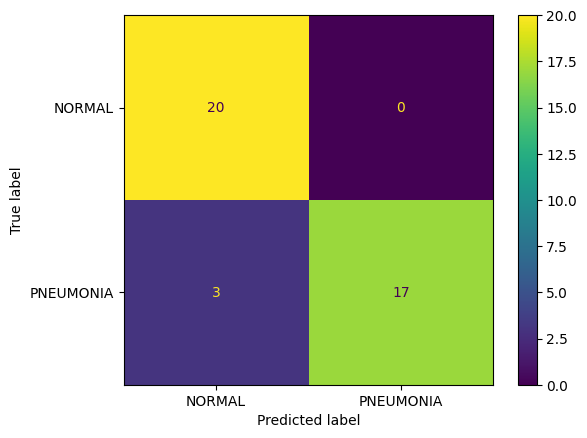

In [ ]:
cm = ConfusionMatrixDisplay.from_predictions(true_class, y_pred_class, display_labels=test_generator.class_indices)
cm

In [ ]:
report = classification_report(true_class, y_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       1.00      0.85      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



In [ ]:
# Random validation

def load_and_preprocess_image(img_path, target_size=(224,224)):
   img = image.load_img(img_path, target_size = target_size)
   img_array = image.img_to_array(img)
   img_array = np.expand_dims(img_array, axis =0)
   img_array /= 255.0
   return img_array

In [ ]:
random_indices = random.sample(range(len(test_df)), 6)

random_images_paths = test_df.iloc[random_indices]['FilePaths'].tolist()
random_images_labels = test_df.iloc[random_indices]['Labels'].tolist()

images = [load_and_preprocess_image(img_path) for img_path in random_images_paths]
images = np.vstack(images)

predictions = best_model.predict(images)
predicted_classes = predictions.argmax(axis=1)

class_labels = { v: k for k, v in train_generator.class_indices.items()}
predicted_labels = [ class_labels[idx] for idx in predicted_classes]

plt.fiqure(figsize=(12,8))

for i, (img_path, actual_label) in enumerate(zip(random_images_paths, random_images_labels)):

    img = image.load_img(img_path, target_size = (224, 224))

    plt.subplot(2,3, i + 1)
    plt.imshow(img)
    plt.title(f"  Actual: { actual_label}\nPredicted: {predicted_labels[i]} ")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


AttributeError: module 'matplotlib.pyplot' has no attribute 'fiqure'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


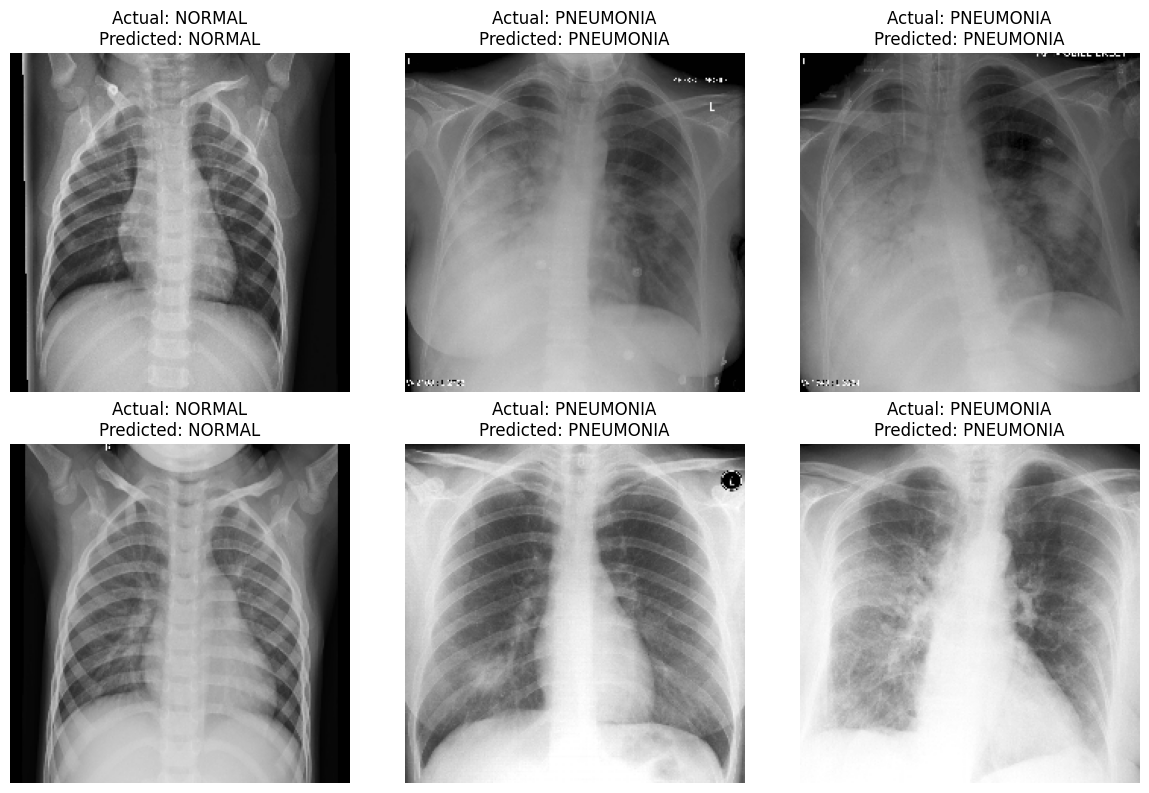

In [ ]:
random_indices = random.sample(range(len(test_df)), 6)
random_images_paths = test_df.iloc[random_indices]['FilePaths'].tolist()
random_images_labels = test_df.iloc[random_indices]['Labels'].tolist()

images = [load_and_preprocess_image(img_path) for img_path in random_images_paths]
images = np.vstack(images)

predictions = best_model.predict(images)
predicted_classes = predictions.argmax(axis=1)

class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_labels = [class_labels[idx] for idx in predicted_classes]

plt.figure(figsize=(12, 8))
for i, (img_path, actual_label) in enumerate(zip(random_images_paths, random_images_labels)):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
plt.fiqure(figsize=(12,8))

for i, (img_path, actual_label) in enumerate(zip(random_images_paths, random_images_labels)):

    img = image.load_img(img_path, target_size = (224, 224))

    plt.subplot(2,3, i + 1)
    plt.imshow(img)
    plt.title(f  Actual: { actual_label}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (ipython-input-3870751717.py, line 9)